## Konvektiver + Diffusiver Transport = Burgersgleichung

### 1D-Burgersgleichung (Konvektion + Diffusion)

Die [Burgersgleichung](https://de.wikipedia.org/wiki/Burgersgleichung) entpsricht der Navier-Stokes-Gleichung ohne Quellterme bzw. der Addition aus konvektivem und diffusiven Transport. Im eindimensionalen Fall ergibt sich also folgende Gleichung:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}$$

Die Burgersgleichung ist nicht nur für die Strömungsmechanik relevant, sondern taucht auch in anderen physikalischen Problemen auf, wie z.B. bei der Simulation des Straßenverkehrs.

Da wir die Diskretisierung der einzelnen Terme bereits durchgeführt haben, ist dieser Schritt trivial. Wir wenden wieder ein einseitiges (Vorwärts-)Differenzenverfahren für die Diskretisierung in der Zeit, ein einseitiges (Rückwärts-)Differenzenverfahren für die konvektiven Terme und ein Zentraldifferenzenverfahren für die zweiten Ableitungen der diffusiven Terme an und erhalten:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Wieder können wir nach den gesuchten Geschwindigkeiten zum neuen Zeitpunkt explizit auflösen:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

#### Anfangs- und Randbedingungen

Eigentlich könnten wir die Gleichung nun sofort in Pyton umsetzen. Da die 1D-Burgersgleichung jedoch für bestimmte Anfangs- und Randbedingungen mit Hilfe einer [Cole-Hopf-Transformation](https://de.wikipedia.org/wiki/Hopf-Cole-Transformation) (mehr was für Mathematiker) analytisch lösbar ist, wollen wir die Gelegenheit nutzen und unsere numerische Lösung mit der analyitschen Lösung vergleichen.

Dazu müssen wir als Anfangsbedingung folgende Geschwindigkeitsverteilung realisieren:

$$u = -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \quad\text{mit}\\\
\phi = \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)$$

und periodische Randbedingungen vorsehen:

$$u(0) = u(2\pi)$$

Für diesen Fall lautet die Lösung der Burgersgleichung:

$$u = -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \quad\text{mit}\\\
\phi = \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)$$

Die Anfangsbedingung entspricht also der Lösung für den Zeitpunkt $t=0$.

##### Verwendung von SymPy

Um die Anfangsbedingung und die Lösung auszurechnen müssen wir die Ableitung von $\phi$ berechnen, was eigentlich nicht weiter schwer ist. Trotzdem soll an dieser Stelle [`SymPy`](http://www.sympy.org/en/index.html) eingeführt werden, mit dem symbolische Mathematik (ähnlich Wolfram Alpha, Mathematica oder Maple) in Python möglich ist.

Wir laden zunächst wieder die benötigen Bibliotheken. Neben `numpy` brauchen wir nun auch `sympy`:

In [2]:
import numpy as np
import sympy as sp

Wenn man mit dem Jupyter-Notebook arbeitet, kann man SymPy so konfigurieren, dass es die Formeln mithifle von $\LaTeX$ rendert. 

In [3]:
from sympy import init_printing
init_printing(use_latex=True)

Zunächst müssen die Variablen, die in der Gleichung für $phi$ vorkommen als symbolische Variablen definiert werden. Anschließend können wir die Gleichung in SymPy zuweisen:

In [4]:
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))
phi

Damit ist es nun ganz einfach, die Ableitung von $phi$ nach dem Ort zu bilden:

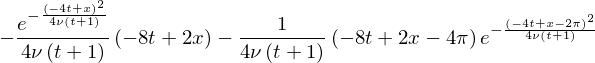

In [5]:
dphidx = phi.diff(x)
dphidx

Um die nicht-gerenderte version der Funktion zu bekommen, kann man diese einfach mit dem `print`-Befehl ausgeben:

In [6]:
print (dphidx)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


Die Funktion ist in dieser Form allerdings noch nicht in Python aufrufbar. Wir könnten diese z.B. abtippen und in eine Python-Funktion umsetzen (mit `def`...).

Eleganter ist es, die `lambdify`-Funktion von SymPy zu nutzen, die genau das für uns macht, ohne dass wit etwas abtippen müssen:

In [7]:
from sympy.utilities.lambdify import lambdify

# Der Ausdruck für u:
u_sym = -2 * nu * (dphidx / phi) + 4

# Und die daraus automatisch erzeugte Python-Funktion u
u_analytisch = lambdify((t, x, nu), u_sym)
print(u_analytisch(1, 4, 3))

3.49170664206


Damit haben wir sowohl eine Funktion, mit der wir die Anfangsbedingung zum Zeitpunkt $t=0$ als auch die Lösung zu jedem beliebigen Zeitpunkt berechnen können.

Jetzt geht es an die Lösung der Burgersgleichung:

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

# benötigte Variablen
L  = 2 * np.pi      # Länge unseres Rechengebiets
nx = 101             # Anzahl der diskreten Punkte
dx = L / (nx-1)     # Abstand zwischen den Punkten
t_end = 1.4        # Endzeitpunkt für die Berechnung
nu  = 0.07          # die kinematische Viskosität in m^2/s
CFL = 0.1
dt = CFL * dx * nu  # Zeitschrittweite

# Anfangsbedingung 
xi = np.linspace(0, L, nx)
u_init = np.asarray([u_analytisch(0, x, nu) for x in xi])

u_alt = u_init.copy()  # wir übernehmen zunächst einmal die Anfangsbedingung
u_neu = u_alt.copy()
t = 0                  # der Anfangszeitpunkt ist 0

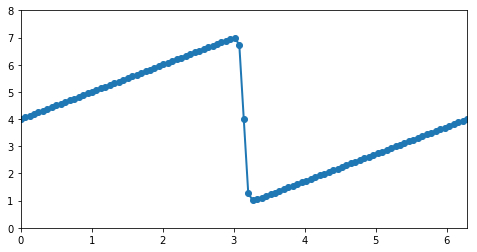

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(xi, u_init, marker='o', lw=2)
plt.xlim([0, L])
plt.ylim([0, 8]);

Die Anfangsverteilung ist nun eher eine Diskontinuität. Deutlich wird auch, dass diese periodisch verläuft, d.h. der Wert am Ende unseres Rechengebiets bei $x=2\pi$ entspricht dem Wert bei $x=0$.

#### Periodische Randbedingungen

Neu im Gegensatz zu den bisherigen Berechnungen ist die Verwendung von periodischen Randbedingungen. D.h. alles was aus dem rechten Rand hinausströmt muss am linken Rand wieder hineinströmen.

Betrachten wir die diskretisierte Burgersgleichung:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

Was müssen wir für $u_{i+1}^n$ verwenden, wenn $i$ bereits am rechten Rand des Gebietes ist und was für $u_{i-1}^n$, wenn $i = 0$ ist?

In [26]:
while t <= t_end:      # Schleife, solange bis Endzeitpunkt erreicht ist
    # dieses Mal mit innerer Schleife zum besseren Verständnis
    # ginge aber auch wieder direkt mit der zuvor eingeführten
    # Schreibweise
    for i in range(1, nx-1):
        u_neu[i] = (u_alt[i] 
                    - u_alt[i] * dt / dx *(u_alt[i] - u_alt[i-1]) 
                    + nu * dt / dx**2 
                    * (u_alt[i+1] - 2 * u_alt[i] + u_alt[i-1]))
    # periodische Randbedingungen:
    u_neu[0] = (u_alt[0] 
                - u_alt[0] * dt / dx * (u_alt[0] - u_alt[-1]) 
                + nu * dt / dx**2 
                * (u_alt[1] - 2 * u_alt[0] + u_alt[-1]))
    u_neu[-1] = (u_alt[-1] 
                 - u_alt[-1] * dt / dx * (u_alt[-1] - u_alt[-2]) 
                 + nu * dt / dx**2
                 * (u_alt[0]- 2 * u_alt[-1] + u_alt[-2]))
    u_alt = u_neu.copy()
    t += dt   

In [27]:
u_analytisch_t_end = np.asarray([u_analytisch(t_end, x, nu) for x in xi])

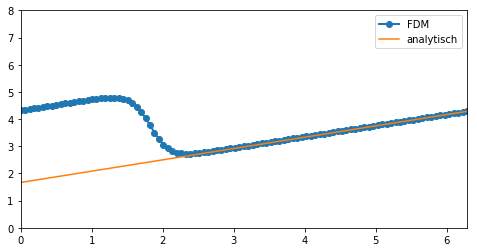

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(xi, u_neu, marker='o', lw=2, label='FDM')
plt.plot(xi, u_analytisch_t_end, label='analytisch')
plt.xlim([0, L])
plt.ylim([0, 8])
plt.legend();

Experimentieren Sie ein wenig mit der Diskretisierung. Welche Auflösung benötigen wir, um die analytische Lösung genau zu treffen?

Wir sind jetzt schon sehr nahe an der Lösung der kompletten Navier-Stokes-Gleichung. Die 2D-Burgersgleichung sparen wir uns, da sie keine neuen Erkenntnisse bringt.

Im nächsten Notebook nehmen wir uns dafür die [2D-Poisson-Gleichung](TFD - 3.8 Kontinuumsstroemungen - Poisson.ipynb) vor, die wir zuvor bereits eingeführt haben.


---
Dieses Notebook folgt einer Idee von Lorena A. Barba und deren exzellenter Ausarbeitung in Python (["12 Steps to Navier Stokes"](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)).

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [170]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()